In [9]:
import os
from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from style import plot_style

In [43]:
_notebook_dir = os.getcwd()

PROJECT_ROOT = Path(_notebook_dir, "..")

DATA_DIR = Path(PROJECT_ROOT, "data/processed")

table_name = Path("bc_filter_timed_20251120_113309.csv")

table_path = Path(DATA_DIR, table_name)

df_t4 = pl.read_csv(table_path)

In [44]:
print(df_t4.head())

# Number of sequences that passed the filters
print(df_t4.filter(pl.col("pass_filters") == True))

# Number of sequences that didn't
print(df_t4.filter(pl.col("pass_filters") == False).shape)

shape: (5, 7)
┌────────────────────┬────────┬───────────┬─────────────┬──────────┬────────────────┬──────────────┐
│ sequence           ┆ length ┆ load_time ┆ filter_time ┆ af2_time ┆ pyrosetta_time ┆ pass_filters │
│ ---                ┆ ---    ┆ ---       ┆ ---         ┆ ---      ┆ ---            ┆ ---          │
│ str                ┆ i64    ┆ f64       ┆ f64         ┆ i64      ┆ i64            ┆ bool         │
╞════════════════════╪════════╪═══════════╪═════════════╪══════════╪════════════════╪══════════════╡
│ DQNVKLWFPFYPTLWWPC ┆ 40     ┆ 7.996236  ┆ 37.047615   ┆ 0        ┆ 0              ┆ false        │
│ FMNFICECIETE…      ┆        ┆           ┆             ┆          ┆                ┆              │
│ DEACGGHCSNLHWTFRHN ┆ 40     ┆ 7.996236  ┆ 5.009805    ┆ 0        ┆ 0              ┆ false        │
│ DIMHCSSEHWQM…      ┆        ┆           ┆             ┆          ┆                ┆              │
│ TYMRNPFCDKSEAMMGVH ┆ 40     ┆ 7.996236  ┆ 5.024385    ┆ 0        ┆ 0       

In [ ]:
def preprocess_runtime_df(df):
    print(df.select("filter_time").mean())

    max_runtimes_per_len = df.group_by("length").agg(
        pl.col("filter_time").max().alias("max_filter_time")
    )

    print(max_runtimes_per_len)

    df_no_max = (
        df.join(max_runtimes_per_len, on="length")
        .filter(pl.col("filter_time") != pl.col("max_filter_time"))
        .select(df.columns)
    )
    mean_nonmax_runtimes_per_len = df_no_max.group_by("length").mean()

    print(mean_nonmax_runtimes_per_len)

    # Joining both tables
    if "filter_time" not in max_runtimes_per_len.columns:
        max_runtimes_per_len = max_runtimes_per_len.rename({"max_filter_time":"filter_time"})

    max_runtimes_per_len = max_runtimes_per_len.with_columns(
        pl.lit("First run").alias("Run")
    )

    mean_nonmax_runtimes_per_len = mean_nonmax_runtimes_per_len.with_columns(
        pl.lit("Subsequent runs").alias("Run")
    )

    runtime_df = pl.concat([max_runtimes_per_len, mean_nonmax_runtimes_per_len], how="diagonal")
    runtime_df = runtime_df.sort("length")
    return runtime_df

In [45]:
runtime_t4 = preprocess_runtime_df(df_t4)

shape: (1, 1)
┌─────────────┐
│ filter_time │
│ ---         │
│ f64         │
╞═════════════╡
│ 11.366723   │
└─────────────┘
shape: (7, 2)
┌────────┬─────────────────┐
│ length ┆ max_filter_time │
│ ---    ┆ ---             │
│ i64    ┆ f64             │
╞════════╪═════════════════╡
│ 50     ┆ 37.896556       │
│ 90     ┆ 42.723541       │
│ 40     ┆ 37.047615       │
│ 100    ┆ 44.685868       │
│ 70     ┆ 39.631567       │
│ 60     ┆ 39.68692        │
│ 80     ┆ 42.703593       │
└────────┴─────────────────┘
shape: (7, 7)
┌────────┬──────────┬───────────┬─────────────┬──────────┬────────────────┬──────────────┐
│ length ┆ sequence ┆ load_time ┆ filter_time ┆ af2_time ┆ pyrosetta_time ┆ pass_filters │
│ ---    ┆ ---      ┆ ---       ┆ ---         ┆ ---      ┆ ---            ┆ ---          │
│ i64    ┆ str      ┆ f64       ┆ f64         ┆ f64      ┆ f64            ┆ f64          │
╞════════╪══════════╪═══════════╪═════════════╪══════════╪════════════════╪══════════════╡
│ 50     ┆ nul

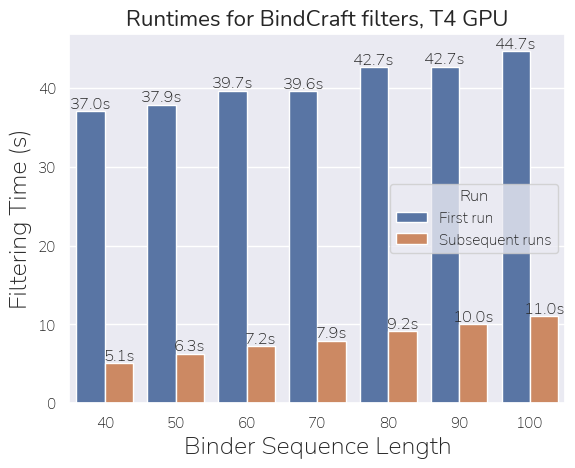

In [51]:
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='nunito', font_scale=1, color_codes=True)
def plot_runtimes(runtime_df, gpu_name=""): 
    ax = sns.barplot(runtime_df, x="length", y="filter_time", hue="Run")
    ax.bar_label(ax.containers[0], fmt="{:.1f}s", fontsize=12)
    ax.bar_label(ax.containers[1], fmt="{:.1f}s", fontsize=12)
    ax.set_xlabel("Binder Sequence Length", fontsize=18)
    ax.set_ylabel("Filtering Time (s)", fontsize=18)
    figtitle = f"Runtimes for BindCraft filters, {gpu_name} GPU"
    ax.set_title(figtitle, fontsize=16)
    plt.savefig(f"plots/{figtitle}")

plot_runtimes(runtime_t4, gpu_name="T4")

In [47]:
table_name = Path("bc_filter_timed_20251124_135440.csv")

table_path = Path(DATA_DIR, table_name)

df_a100 = pl.read_csv(table_path)

shape: (1, 1)
┌─────────────┐
│ filter_time │
│ ---         │
│ f64         │
╞═════════════╡
│ 7.069652    │
└─────────────┘
shape: (7, 2)
┌────────┬─────────────────┐
│ length ┆ max_filter_time │
│ ---    ┆ ---             │
│ i64    ┆ f64             │
╞════════╪═════════════════╡
│ 60     ┆ 51.75108        │
│ 40     ┆ 48.484083       │
│ 50     ┆ 48.464303       │
│ 90     ┆ 50.053357       │
│ 80     ┆ 50.486561       │
│ 100    ┆ 53.07163        │
│ 70     ┆ 49.699174       │
└────────┴─────────────────┘
shape: (7, 7)
┌────────┬──────────┬───────────┬─────────────┬──────────┬────────────────┬──────────────┐
│ length ┆ sequence ┆ load_time ┆ filter_time ┆ af2_time ┆ pyrosetta_time ┆ pass_filters │
│ ---    ┆ ---      ┆ ---       ┆ ---         ┆ ---      ┆ ---            ┆ ---          │
│ i64    ┆ str      ┆ f64       ┆ f64         ┆ f64      ┆ f64            ┆ f64          │
╞════════╪══════════╪═══════════╪═════════════╪══════════╪════════════════╪══════════════╡
│ 100    ┆ nul

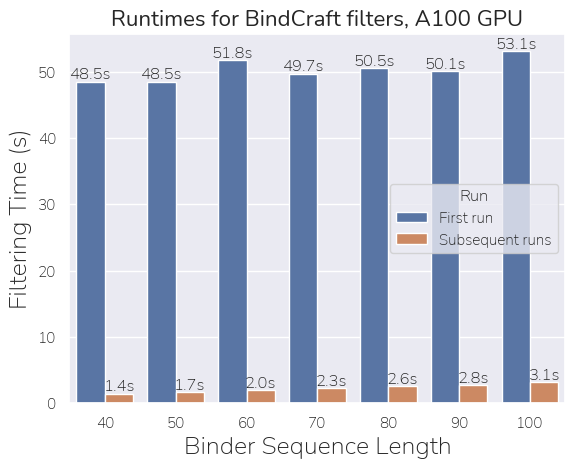

In [52]:
runtime_a100 = preprocess_runtime_df(df_a100)

plot_runtimes(runtime_a100, gpu_name="A100")